<a href="https://colab.research.google.com/github/shreyanshchordia/image_auto_encoder/blob/master/convolutional_image_encoder/convolutional_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchsummary

In [0]:
import numpy as np
import tensorflow as tf
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchsummary import summary

In [0]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std= (0.5))
])

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [0]:
train_dataset = MNIST('./data',
                      train = True,
                      transform = img_transform,
                      download = True)

train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = 4)

test_dataset = MNIST('./data',
                      train = False,
                      transform = img_transform,
                      download = True)

test_dataloader = DataLoader(test_dataset,
                              batch_size = BATCH_SIZE//2,
                              shuffle = True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
print(len(train_dataset),
      len(test_dataset))

60000 10000


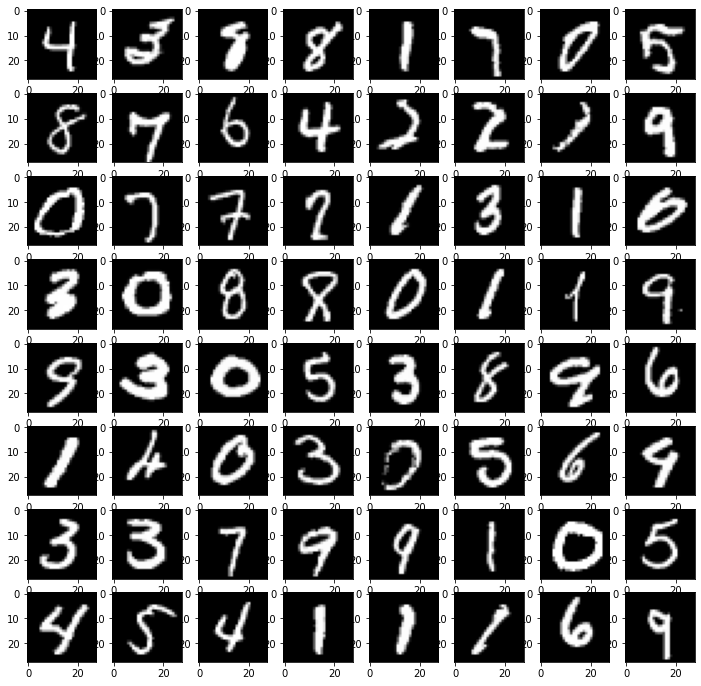

In [0]:
imgs,_ = next(iter(test_dataloader))
fig = plt.figure(figsize=(12,12))
for i,image in enumerate(imgs[:64]):

    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 16, 5, 5

            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  #16, 5, 5
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 8, 15, 15
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encodings(self, x):
        e = self.encoder(x)
        return e

In [0]:
model = autoencoder().cuda()
cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = LEARNING_RATE,
                             weight_decay=1e-5)

In [0]:
def to_img(x):
    x = (0.5 * x) + 0.5
    return (x.view(x.shape[0],1,28,28))

In [0]:
def train_model(model,dataloader,num_epochs,cost,optimizer):

    loss_values = []

    for epoch in range(1,num_epochs+1):

        for data in dataloader:
            img, _ = data
            img = Variable(img).cuda()

            # =================== forward =====================
            output = model(img)
            loss = cost(output, img)
            # =================== backward ====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # =================== log ========================


        print('epoch [{}/{}], loss:{:.4f}'.format(epoch, 
                                                 num_epochs, 
                                                  loss.data))
        loss_values.append(loss.data)

        if(epoch==1 or epoch%10==0):
            pic = to_img(output.cpu().data)
            save_image(pic, '/content/drive/My Drive/Colab Notebooks/stage/epoch_{}.png'.format(epoch))
        
    return loss_values

In [0]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 10, 10]             160
              ReLU-2           [-1, 16, 10, 10]               0
         MaxPool2d-3             [-1, 16, 5, 5]               0
            Conv2d-4              [-1, 8, 3, 3]           1,160
              ReLU-5              [-1, 8, 3, 3]               0
         MaxPool2d-6              [-1, 8, 2, 2]               0
   ConvTranspose2d-7             [-1, 16, 5, 5]           1,168
              ReLU-8             [-1, 16, 5, 5]               0
   ConvTranspose2d-9            [-1, 8, 15, 15]           3,208
             ReLU-10            [-1, 8, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              33
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 5,729
Trainable params: 5,729
Non-trainable params: 0
-----------------------------------

In [0]:
loss_history = train_model(model,train_dataloader,EPOCHS,cost,optimizer)

epoch [1/100], loss:0.2282
epoch [2/100], loss:0.1772
epoch [3/100], loss:0.1823
epoch [4/100], loss:0.1668
epoch [5/100], loss:0.1584
epoch [6/100], loss:0.1464
epoch [7/100], loss:0.1401
epoch [8/100], loss:0.1348
epoch [9/100], loss:0.1387
epoch [10/100], loss:0.1329
epoch [11/100], loss:0.1390
epoch [12/100], loss:0.1228
epoch [13/100], loss:0.1356
epoch [14/100], loss:0.1197
epoch [15/100], loss:0.1259
epoch [16/100], loss:0.1206
epoch [17/100], loss:0.1105
epoch [18/100], loss:0.1190
epoch [19/100], loss:0.1185
epoch [20/100], loss:0.1172
epoch [21/100], loss:0.1214
epoch [22/100], loss:0.1216
epoch [23/100], loss:0.1139
epoch [24/100], loss:0.1108
epoch [25/100], loss:0.1164
epoch [26/100], loss:0.1062
epoch [27/100], loss:0.1222
epoch [28/100], loss:0.1136
epoch [29/100], loss:0.1146
epoch [30/100], loss:0.1087
epoch [31/100], loss:0.1070
epoch [32/100], loss:0.1180
epoch [33/100], loss:0.1178
epoch [34/100], loss:0.1092
epoch [35/100], loss:0.1137
epoch [36/100], loss:0.1138
e

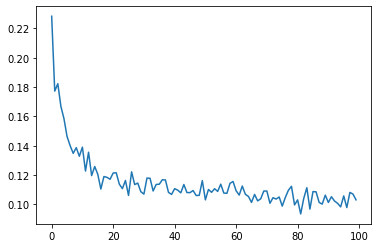

In [0]:
history = np.asarray(loss_history)
plt.plot(history)
plt.show()

The input set of images



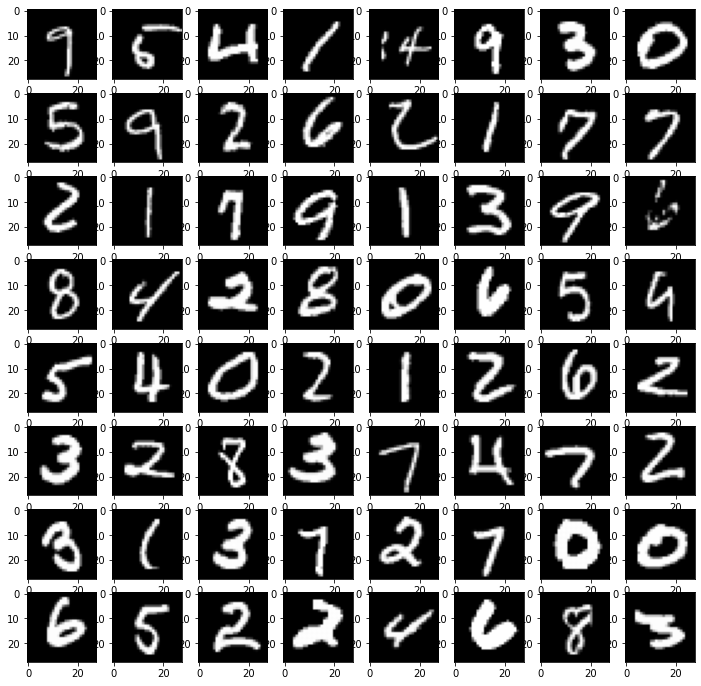

Achieved outputs



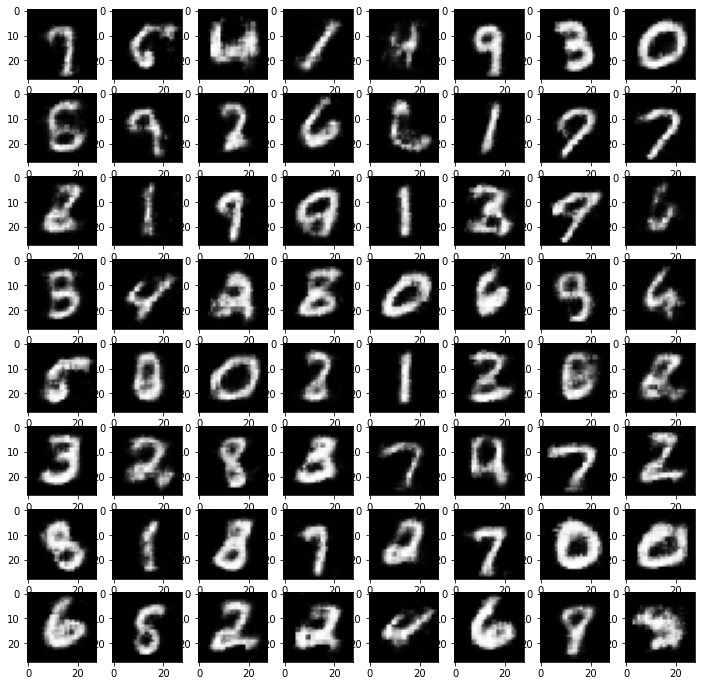

In [0]:
imgs,_ = next(iter(test_dataloader))
fig = plt.figure(figsize=(12,12))
x = imgs[:64]

print("The input set of images\n")

for i,image in enumerate(x):

    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

print("Achieved outputs\n")

fig = plt.figure(figsize=(12,12))
x = Variable(imgs[:64]).cuda()
x = model(x).cpu().detach().numpy()
for i,image in enumerate(x):
    plt.subplot(8,8,i+1)
    image = (np.asarray(image).reshape(28,28) * 0.5) + 0.5  # unflattening and rescaling
    plt.imshow(image, cmap = 'gray')

plt.show()

In [0]:
imgs,_ = next(iter(test_dataloader))
imgs = imgs[:8].cuda()

encoded = model.encodings(imgs)
output = model(imgs)
print(encoded.shape,output.shape)

torch.Size([8, 8, 2, 2]) torch.Size([8, 1, 28, 28])


The 32 feature encodings (8 X 2 X 2) corresponding to each 28 X 28 image


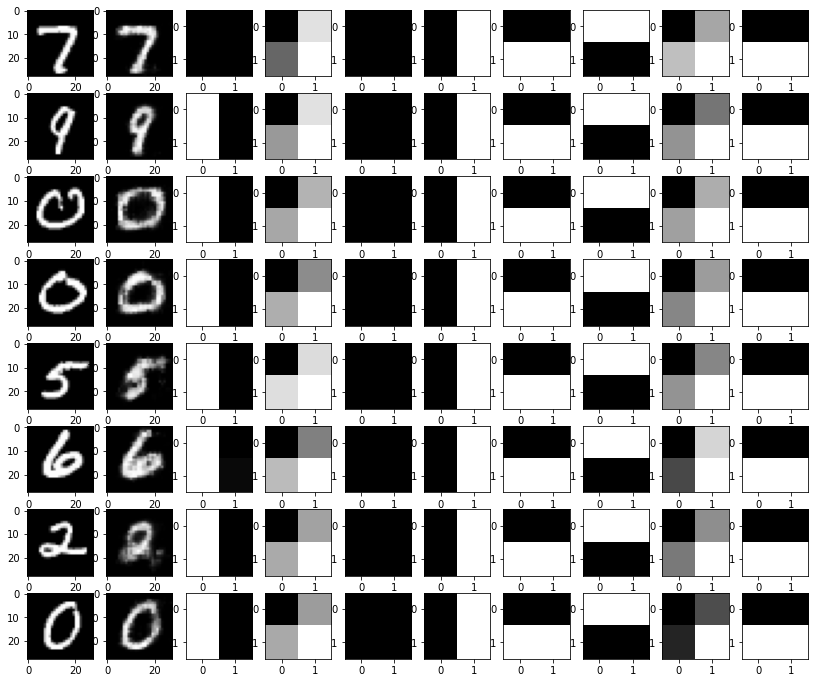

In [0]:
plt.figure(figsize=(14,12))
print("The 32 feature encodings (8 X 2 X 2) corresponding to each 28 X 28 image")
count = 1
for i, op in enumerate(output):

    # input image
    plt.subplot(8,10,count)
    img = np.asarray(imgs[i].cpu().detach())
    img = (img).reshape(28,28)
    plt.imshow(img, cmap = 'gray')
    count+=1

    # output
    plt.subplot(8,10,count)
    op = np.asarray(op.cpu().detach())
    image = (op).reshape(28,28)
    plt.imshow(image, cmap = 'gray')
    count+=1

    # encodings
    for en in encoded[i]:

        plt.subplot(8,10,count)
        en = np.asarray(en.cpu().detach())
        image = (en).reshape(2,2)
        plt.imshow(image, cmap='gray')
        count+=1

plt.show()

In [0]:
torch.save(model.state_dict(),"/content/drive/My Drive/Colab Notebooks/stage/auto_encoder_conv.pth")